# Ranking heuristics & Graph-Based signals: Experiments and Evaluation

This notebook implements and evaluates ranking heuristics and graph based signals.
For ranking heuristics mix of popularity and recency based ranking was used: final score is the number of book occurences in train set, weighted with time decay factor $2^{-\Delta t / h}$, where $h$ is half-life factor and equals 30 days. This way we penalize older ratings and assign more relevance to newer ones.

For graph-based approach we calculate edges between books as number of times two books were rated by the same user with cosine normalization, to compensate for popularity factor.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.data.loader import load_all_data
from src.data.splitter import create_temporal_split, SplitConfig, add_random_timestamps, UserTemporalSplitConfig
from src.evaluation import (
    EvaluationPipeline,
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Data Loading and Temporal Split

For this task temporal split we use differs from similarity recommendation algorithms. If we split by the year the book was published, matrix factorization inherently make no sense, as all of the validation and test books will face cold start problem. Therefore we create random variable timestamp, that simulates time the book was rated. Then, for each user we order ratings by timestamp and split train/val/test with 0.7/0.15/0.15 ratio, so that older books go in train and newer into validation and test. This creates simulation of temporal data.

In [13]:
# Load data
ratings, books, users = load_all_data('../data/raw')

ratings_ts = add_random_timestamps(ratings, start="2004-08-01", end="2004-09-30", seed=123, ts_col="timestamp")
K_VALUES = [10]



## 2. Popularity/recency-based ranking
### 2.1 relevance_threshold = 6

In [14]:
# Create temporal split
config = UserTemporalSplitConfig(
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    min_train=1,
    min_val=1,
    min_test=1,
    min_user_interactions = 10,
    min_item_interactions = 10,
    explicit_only = True
)


train_df, val_df, test_df, split_info = create_temporal_split(ratings_ts, books, "users", config)
test_df = pd.concat([test_df, val_df], axis=0, ignore_index=True)


--- Step 1: Filtering data ---
Original ratings: 1,149,780
After explicit filter: 433,671 ratings
After year filter (1900-2004): 377,822 ratings
Iteration 1: 71,437 ratings, 6,037 users, 3,244 items
Iteration 2: 46,508 ratings, 2,209 users, 2,237 items
Iteration 3: 42,355 ratings, 1,888 users, 2,066 items
Iteration 4: 41,433 ratings, 1,823 users, 2,027 items
Iteration 5: 41,262 ratings, 1,811 users, 2,020 items
Iteration 6: 41,253 ratings, 1,810 users, 2,020 items
Iteration 7: 41,253 ratings, 1,810 users, 2,020 items

--- Step 2: Temporal split ---
Initial split sizes (by user timestamp):
  Train: 28,144 ratings
  Val: 5,252 ratings
  Test: 7,857 ratings

--- Step 3: Ensuring test users have training history ---

--- Final Split Summary ---
Set             Ratings      Users      Items           Years   Avg Rating
----------------------------------------------------------------------
train            28,144      1,810      2,020       1930-2004         7.96
val               5,252    

In [17]:
train_items = set(train_df['isbn'].unique())
test_items = set(test_df['isbn'].unique())
overlap = train_items & test_items

print("TEMPORAL SPLIT")
print("=" * 50)
print(f"Train items: {len(train_items):,}")
print(f"Test items: {len(test_items):,}")
print(f"Overlap (items in both): {len(overlap)}")

# Shared users
train_users = set(train_df['user_id'].unique())
test_users = set(test_df['user_id'].unique())
shared_users = train_users & test_users
print(f"\nShared users (in both train and test): {len(shared_users):,}")
print(f"Test-only users: {len(test_users - train_users):,}")

TEMPORAL SPLIT
Train items: 2,020
Test items: 2,008
Overlap (items in both): 2008

Shared users (in both train and test): 1,810
Test-only users: 0


In [18]:
from datetime import datetime
today = datetime.strptime('2004-09-30 00:12:53', "%Y-%m-%d %H:%M:%S")


In [19]:
h = 30
train_df['implicit_style'] = np.where(train_df['rating'] != 0, 1, 0)
train_df['delta_t'] = (today - train_df['timestamp']).dt.total_seconds()/(3600*24)
train_df['decay'] = 2**(-train_df['delta_t']/h)
train_df['score'] = train_df['decay']*train_df['implicit_style']
occurences = train_df[['isbn', 'implicit_style']].groupby(['isbn']).sum('implicit_style').reset_index()
items_scores_grouped = train_df[['isbn', 'score']].groupby(['isbn']).sum('score').sort_values(by = 'score', ascending = False).reset_index()
items_scores_grouped = items_scores_grouped.merge(occurences, how = 'left', on = 'isbn')


In [20]:
items_scores_grouped

,isbn,score,implicit_style
0,0316666343,62.178762,149
1,0385504209,53.490881,126
2,0312195516,39.957661,95
3,0142001740,37.608377,89
4,0446672211,33.737865,82
...,...,...,...
2015,0553284118,1.148271,4
2016,0515119784,1.135834,3
2017,0446359750,1.071198,3
2018,0802135196,1.023922,3


In [22]:
# Evaluate popularity/recency-based methods - Ranking
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=6)

all_results = {}
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
heuristics_ranking = pipeline.evaluate_ranking_heuristic(items_scores_grouped['isbn'], test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {heuristics_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {heuristics_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {heuristics_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {heuristics_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

# Merge results
all_results['Heuristics_min6'] = heuristics_ranking

Evaluating ranking (this may take a few minutes)...
test_df len 1810
6
user_relevant len 1798
1798
  NDCG@10:     0.0361
  Precision@10: 0.0217
  Hit Rate@10:  0.1902
  Users eval'd: 1798
  Time: 0.2s


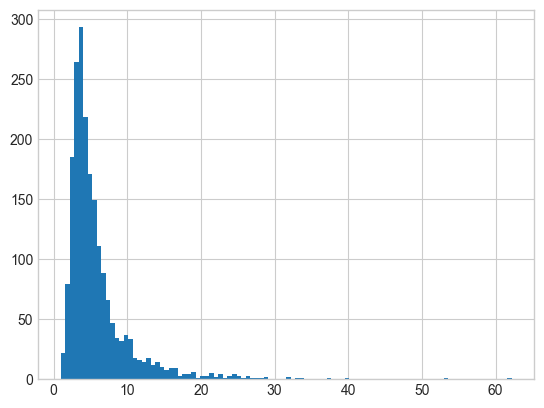

In [23]:
plt.hist(items_scores_grouped['score'], bins = 100)
plt.show()

In [25]:
items_scores_grouped.head(5).merge(books[['isbn', 'title', 'author']].drop_duplicates())

,isbn,score,implicit_style,title,author
0,0316666343,62.178762,149,The Lovely Bones: A Novel,Alice Sebold
1,0385504209,53.490881,126,The Da Vinci Code,Dan Brown
2,0312195516,39.957661,95,The Red Tent (Bestselling Backlist),Anita Diamant
3,0142001740,37.608377,89,The Secret Life of Bees,Sue Monk Kidd
4,0446672211,33.737865,82,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts


### 2.2 relevance_threshold = 1

In [26]:
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=1)
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
heuristics_ranking = pipeline.evaluate_ranking_heuristic(items_scores_grouped['isbn'], test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {heuristics_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {heuristics_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {heuristics_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {heuristics_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

all_results['Heuristics_min1'] = heuristics_ranking

Evaluating ranking (this may take a few minutes)...
test_df len 1810
1
user_relevant len 1810
1810
  NDCG@10:     0.0358
  Precision@10: 0.0233
  Hit Rate@10:  0.2017
  Users eval'd: 1810
  Time: 0.3s


## 3. Graph based approach
### 3.1 relevance_threshold = 6

In [27]:
from collections import Counter, defaultdict
from itertools import combinations
from math import sqrt


user_items = train_df.groupby("user_id")["isbn"].apply(lambda x: pd.unique(x).tolist())

pair_cnt = Counter()
item_cnt = Counter()

for items in user_items:
    for i in items:
        item_cnt[i] += 1
    for i, j in combinations(sorted(items), 2):
        pair_cnt[(i, j)] += 1

neighbors = defaultdict(list)  

for (i, j), cij in pair_cnt.items():
    sim = cij / sqrt(item_cnt[i] * item_cnt[j])
    neighbors[i].append((j, sim))
    neighbors[j].append((i, sim))

M = 200 

for i in list(neighbors.keys()):
    neighbors[i].sort(key=lambda x: x[1], reverse=True)
    neighbors[i] = neighbors[i][:M]

In [28]:
for (i, j), cij in pair_cnt.most_common(10):
    print(books[books['isbn'] == i]['title'].drop_duplicates().item(), '\t', books[books['isbn'] == j]['title'].drop_duplicates().item(), '\t', cij)

Harry Potter and the Chamber of Secrets (Book 2) 	 Harry Potter and the Prisoner of Azkaban (Book 3) 	 31
Harry Potter and the Chamber of Secrets (Book 2) 	 Harry Potter and the Sorcerer's Stone (Book 1) 	 27
Harry Potter and the Prisoner of Azkaban (Book 3) 	 Harry Potter and the Sorcerer's Stone (Book 1) 	 23
Harry Potter and the Prisoner of Azkaban (Book 3) 	 Harry Potter and the Goblet of Fire (Book 4) 	 22
Harry Potter and the Chamber of Secrets (Book 2) 	 Harry Potter and the Goblet of Fire (Book 4) 	 21
Harry Potter and the Chamber of Secrets (Book 2) 	 Harry Potter and the Order of the Phoenix (Book 5) 	 21
Harry Potter and the Prisoner of Azkaban (Book 3) 	 Harry Potter and the Order of the Phoenix (Book 5) 	 21
The Lovely Bones: A Novel 	 The Da Vinci Code 	 20
Three To Get Deadly : A Stephanie Plum Novel (A Stephanie Plum Novel) 	 Two for the Dough 	 19
Interview with the Vampire 	 The Queen of the Damned (Vampire Chronicles (Paperback)) 	 17


In [29]:
user_hist = train_df.groupby("user_id").apply(
    lambda g: list(zip(g["isbn"].values, g["rating"].values, g["timestamp"].values))
)
user_seen = train_df.groupby("user_id")["isbn"].apply(set)

def recommend_user(u, K=10):
    hist = user_hist.get(u, [])
    seen = user_seen.get(u, set())

    scores = Counter()

    for item_j, r, ts in hist:
        for item_i, sim in neighbors.get(item_j, []):
            if item_i not in seen:
                scores[item_i] += sim

    return [i for i, s in scores.most_common(K)]

recommendations_dict = {}
for user_id in test_df['user_id'].drop_duplicates():
    recommendations_dict[user_id] = recommend_user(user_id, 10)

/var/folders/0l/fh4k0dv16bd0jg5rbzdk8c000000gp/T/ipykernel_7036/3252019286.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_hist = train_df.groupby("user_id").apply(


In [30]:
# Evaluate Graph-based - Ranking
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=6)

print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
graph_ranking = pipeline.evaluate_ranking_graph(recommendations_dict, test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {graph_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {graph_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {graph_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {graph_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

all_results['Graph_min6'] = graph_ranking

Evaluating ranking (this may take a few minutes)...
test_df len 1810
6
user_relevant len 1798
1798
  NDCG@10:     0.0767
  Precision@10: 0.0419
  Hit Rate@10:  0.2608
  Users eval'd: 1798
  Time: 0.1s


### 3.2 relevance_threshold = 1

In [31]:
# Evaluate Graph-based - Ranking
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=1)

print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
graph_ranking = pipeline.evaluate_ranking_graph(recommendations_dict, test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {graph_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {graph_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {graph_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {graph_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

all_results['Graph_min1'] = graph_ranking

Evaluating ranking (this may take a few minutes)...
test_df len 1810
1
user_relevant len 1810
1810
  NDCG@10:     0.0777
  Precision@10: 0.0446
  Hit Rate@10:  0.2746
  Users eval'd: 1810
  Time: 0.1s


## 4. Results comparison

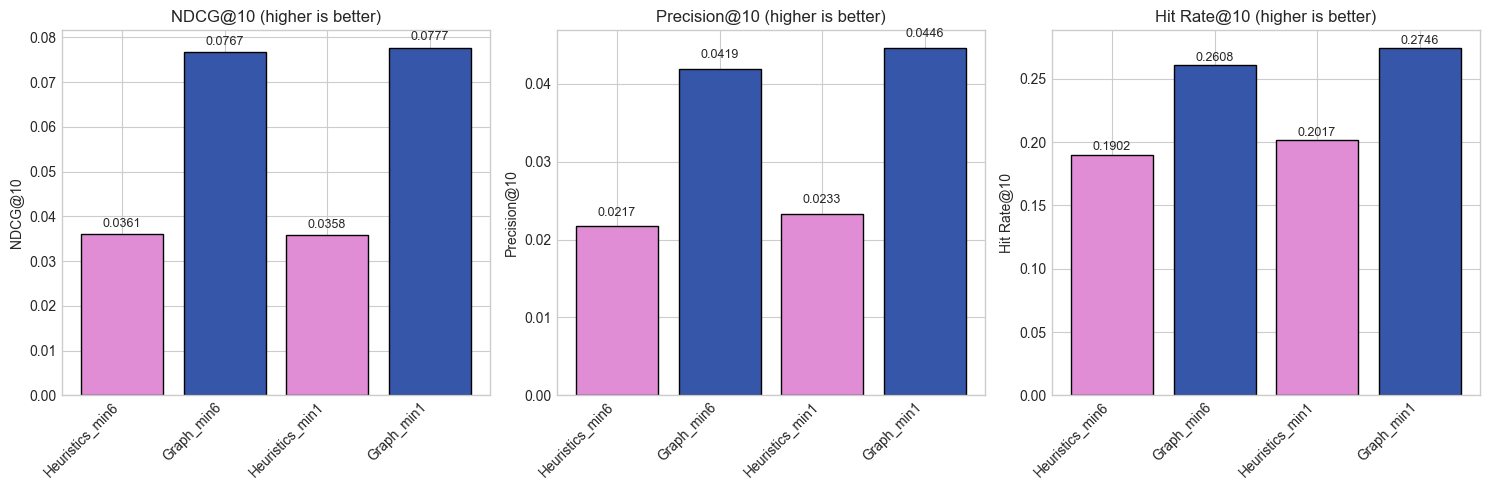

In [32]:
# Visualize ranking metrics (only models that have ranking results)
model_order = ['Heuristics_min6', 'Graph_min6', 'Heuristics_min1', 'Graph_min1']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
ranking_colors = []
for m in model_order:
    if 'Heuristics' in m:
        ranking_colors.append("#e08dd6")
    elif 'Graph' in m:
        ranking_colors.append("#3656A9")


for idx, (metric, title) in enumerate([
    ('ndcg@10', 'NDCG@10'),
    ('precision@10', 'Precision@10'),
    ('hit_rate@10', 'Hit Rate@10')
]):
    ax = axes[idx]
    vals = [all_results[m].get(metric, 0) for m in model_order]
    bars = ax.bar(range(len(model_order)), vals, color=ranking_colors, edgecolor='black')
    ax.set_xticks(range(len(model_order)))
    ax.set_xticklabels(model_order, rotation=45, ha='right')
    ax.set_ylabel(title)
    ax.set_title(f'{title} (higher is better)')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../experiments/similarity_ranking_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## Conclusions

Popularity based with recency decay ranking assumes that items, that many people interacted with in recent time are more relevant for all users. Recommendations are the same for all users, personalization happens only after items user has already rated are removed from suggestions, which inherently makes it strong solution for cold-start problem for users without history or very sparse profiles. However, its lack of personalization is a big problem itself, especially when preferences are heterogeneous. Also, it creates a problem of popular items getting more popular and long-tails get suppressed, that leads to cold-start problem for new items.

Graph-based ranking assumes that items that co-occur in users' histories are similar, which makes it a kind of item-based colaborative filtering. This method contains personalization element as opposed to popularity based ranking heuristic. However it also faces item cold-start problem. Also, without normalization risks of popular items becoming hubs, that after scoring dominate in recommendations.


Based on resulting metrics (NDCG@10, Precision@10, Hit Rate@10) we see that in all methods outperform MF and similarity based approaches. min1 and min6 on plots stand for relevance threshold used for test data. Methods are resistent for relevance threshold and a conclusion that can be made is that they moslty recommend items, that have higher rating to users. Though NDCG@10 and Precision@10 are still pretty low, Hit Rate@10 gets up to 0.27 with graph-based methods and 0.2 with ranking heuristics, meaning that each fourth and fifth user accordingly get 1 relevant item from 10 generated recommendations.